In [1]:
import propagation_methods as propag
import grid_generation as grid
import bounds_common as bounds
import barriers as barriers
import probability_mass_computation as proba
import plot_methods as plot

### Initial state distribution: $x_0 \sim \mathcal{N}([3, 3]], \sigma I)$

In [2]:
METHOD = 'linear'

A = [[0.84, 0.1],
     [0.05, 0.72]]

params = [A]

In [3]:
#Initial distribution
sigma = 0.002

mean_initial_state = [2.0, 2.0]
cov_initial_state = [[sigma, 0.0],
                     [0.0, sigma]]

#Noise structure
sigma_noise = 0.001

mean_noise = [0, 0]
cov_noise = [[sigma_noise/2, 0.0],
             [0.0, 2*sigma_noise]]

#Steps ahead for prediction
n_steps_ahead = 10

In [4]:
sigma**0.5

0.022360679774997897

In [5]:
sigma_noise**0.5

0.03162277660168379

In [6]:
barrier = barriers.createBarrier([1.0, 0.0], [1.5, 0.5])

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

n_simulations = 10

df_mc = pd.DataFrame(columns=np.arange(n_steps_ahead + 1))
actual_prob_hitting = np.zeros(n_steps_ahead + 1)

for n in range(n_simulations):

    evolution = []

    state = propag.getInitialState(mean_initial_state, cov_initial_state)
    if barriers.verifyIfInsideBarrier(state, barrier):
        actual_prob_hitting[0] += 1
    evolution.append(state)



    for t in range(n_steps_ahead):
        state = propag.stateEvolution(state, mean_noise, cov_noise, 1, METHOD, params)
        if barriers.verifyIfInsideBarrier(state, barrier):
            actual_prob_hitting[t + 1] += 1
        evolution.append(state)
    
    df_mc.loc[len(df_mc)] = evolution

actual_prob_hitting = actual_prob_hitting/n_simulations

In [8]:
actual_prob_hitting

array([0. , 0. , 0. , 0. , 0. , 0.1, 0.5, 0.4, 0. , 0. , 0. ])

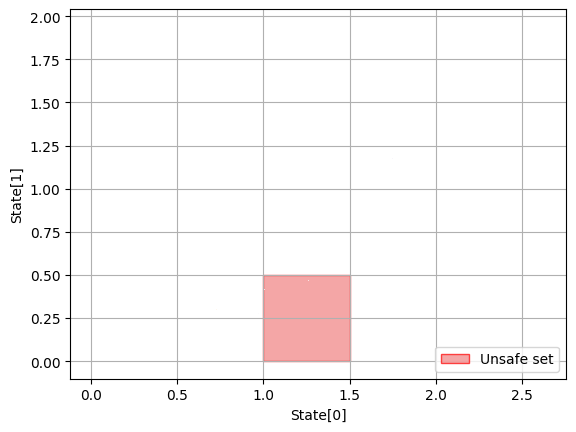

In [9]:
plot.plotPropagationStepByStep(df_mc, barrier)

In [10]:
def adaptRegions(regions):

    regions_adapted = []

    for region in regions:

        a1 = region[0][0]
        a2 = region[0][1]

        b1 = region[1][0]
        b2 = region[1][1]

        regions_adapted.append([[a1, b1], [a2, b2]])

    return np.array(regions_adapted)

In [11]:
#print(div)

In [12]:
df = pd.DataFrame(columns=np.arange(n_steps_ahead + 1))
prob_hitting = np.zeros(n_steps_ahead + 1)

In [13]:
# #T = 0
# hat_gmm = ([1.0], [mean_initial_state], cov_initial_state)

# regions = grid.createRegions([mean_initial_state[0], cov_initial_state[0][0]**0.5], [mean_initial_state[1], cov_initial_state[1][1]**0.5], 4, 200)
# signatures = grid.placeSignatures(regions, 0.5)
# weights = proba.computeSignatureProbabilities(regions, [mean_initial_state], cov_initial_state, [1.0])

#print(len(regions))

#T = 1
#old_weights = weights.copy()
#hat_gmm = (weights, propag.propagateSignatures(signatures, METHOD, params), cov_noise)

#tv_bound = bounds.computeUpperBoundForTV_Modified(signatures, regions, weights, cov_noise, METHOD, params)
#print(tv_bound)

#weights, signatures, regions = propag.propagateUncertaintyOneStep(0.05, regions, signatures, weights, cov_noise, METHOD, params)

#tv_bound = bounds.computeUpperBoundForTV_Modified(signatures, regions, old_weights, cov_noise, METHOD, params)
#print(tv_bound)

#T = 2
#old_weights = weights.copy()
#hat_gmm = (weights, propag.propagateSignatures(signatures, METHOD, params), cov_noise)


#tv_bound = bounds.computeUpperBoundForTV_Modified(signatures, regions, weights, cov_noise, METHOD, params)
#print(tv_bound)

#weights, signatures, regions = propag.propagateUncertaintyOneStep(0.015, regions, signatures, weights, cov_noise, METHOD, params)

#tv_bound = bounds.computeUpperBoundForTV_Modified(signatures, regions, old_weights, cov_noise, METHOD, params)
#print(tv_bound)

In [14]:
# tv_bounds = [0]
# n_signatures_initial = 90
# desired_region_size = 0.002


# regions = grid.createRegions([mean_initial_state[0], cov_initial_state[0][0]**0.5], [mean_initial_state[1], cov_initial_state[1][1]**0.5], 4, n_signatures_initial)
# signatures = grid.placeSignatures(regions, 0.5)
# print(f'Number of regions: {len(signatures)}')

In [15]:
# import bounds_common as bounds
# import numpy as np
# from numpy.linalg import inv
# import bounds_linear_system_2d as bounds_linear

# print(signatures[0])
# print(regions[0])

# vertices = grid.getVertices(regions[0])



# i = 3
# #bounds_linear.insideSumTerm(A, vertices[i], signatures[0], cov_noise, 1)**2
# #bounds_linear.insideSumTerm(A, vertices[i], signatures[0], cov_noise, 0)**2 + bounds_linear.insideSumTerm(A, vertices[i], signatures[0], cov_noise, 1)**2

# x = np.dot(A, np.array(vertices[i]) - np.array(signatures[0]))
# np.sqrt(np.dot(x.T ,np.dot(inv(cov_noise), x)))

In [16]:
# import bounds_linear_system_2d as bounds_linear
# from scipy import special

# #special.erf(bounds_linear.maxValueInsideRegion(A, signatures[0], regions[0], cov_noise)/(2*np.sqrt(2)))
# bounds_linear.maxValueInsideRegion(A, signatures[0], regions[0], cov_noise)/(2*np.sqrt(2))

In [17]:
#regions

In [18]:
tv_bounds = [0]
# n_signatures_initial = 100
desired_region_size = 0.001


#regions = grid.createRegions([mean_initial_state[0], cov_initial_state[0][0]**0.5], [mean_initial_state[1], cov_initial_state[1][1]**0.5], 4, n_signatures_initial)
n_signatures_subregion = [200, 150, 50, 20, 10]
regions = grid.createRegionsAlternative([mean_initial_state[0], cov_initial_state[0][0]**0.5], [mean_initial_state[1], cov_initial_state[1][1]**0.5], n_signatures_subregion)

regions_adapted = adaptRegions(regions)

signatures = grid.placeSignatures(regions, 0.5)
print(f'Number of regions: {len(signatures)}')

#double_hat_proba = proba.computeSignatureProbabilitiesInParallel(regions, [mean_initial_state], cov_initial_state, [1.0])
double_hat_proba = proba.computeSignatureProbabilitiesInParallel(regions_adapted, np.array([mean_initial_state]), np.array([cov_initial_state[0][0], cov_initial_state[1][1]]), np.array([1.0]))


for step in range(n_steps_ahead - 1):

    tv_bound = bounds.computeUpperBoundForTVWithMax(signatures, regions, double_hat_proba, cov_noise, METHOD, params)
    tv_bounds.append(tv_bound)
    print(f'TV bound: {tv_bound}')

    means_gmm = propag.propagateSignatures(signatures, METHOD, params)

    signatures, regions = propag.updateGrid(desired_region_size, regions, signatures, double_hat_proba, cov_noise, METHOD, params)
    print(f'Number of regions: {len(signatures)}')

    regions_adapted = adaptRegions(regions)

    #double_hat_proba = proba.computeSignatureProbabilitiesInParallel(regions, means_gmm, cov_noise, double_hat_proba)
    double_hat_proba = proba.computeSignatureProbabilitiesInParallel(regions_adapted, np.array(means_gmm), np.array([cov_noise[0][0], cov_noise[0][0]]), double_hat_proba)

Number of regions: 139724
Function 'computeSignatureProbabilitiesInParallel' executed in 1.2602s
TV bound: 0.0028639711916459134
Number of regions: 53624


In [ ]:
tv_bounds

[0,
 0.8549832507031869,
 0.01274410871491617,
 0.013099221586214042,
 0.013217786230164383,
 0.013445565963930824,
 0.013512781286845023,
 0.013614057791436615,
 0.013599806186863354,
 0.013667365417665984]

In [ ]:
# samples_collection = []
# probas_collection = []
# tv_bounds = [0]
# n_samples = 10000

# n_steps = range(n_steps_ahead-1) #There is a minus one because the sampleFromGmm already propagates the signatures for sampling, see equations

# desired_region_size = 0.008

# n_signatures = 100
# print(n_signatures)

# gmm = ([1.0], [mean_initial_state], cov_initial_state)


# # ##########################################################################################
# # proba_barrier = proba.gmmProbaMassInsideHypercube(gmm, barrier)
# # probas_collection.append(proba_barrier)
# # ##########################################################################################

# #print(cov_initial_state[0][0]**0.5)

# regions = grid.createRegions([mean_initial_state[0], cov_initial_state[0][0]**0.5], [mean_initial_state[1], cov_initial_state[1][1]**0.5], 4, n_signatures)
# signatures = grid.placeSignatures(regions, 0.5)
# probas = proba.computeSignatureProbabilitiesInParallel(regions, [mean_initial_state], cov_initial_state, [1.0])

# #plot.plot_signatures(signatures, regions, [-2, 8])


# #plot.plot_signatures(signatures, regions, [1.0, 7.0])


# # ##########################################################################################
# # samples = propag.sampleFromGMM(n_samples, probas, signatures, cov_noise, METHOD, params)
# # samples_collection.append(samples)

# # for s in samples:
# #     if barriers.verifyIfInsideBarrier(s, barrier):
# #         prob_hitting[1] += 1
# # ##########################################################################################


# # tv_bound = bounds.computeUpperBoundForTV(signatures, regions, gmm, cov_noise, METHOD, params)
# # print(tv_bound)
# # tv_bounds.append(tv_bound)

# for step in n_steps:

#     gmm = (probas, propag.propagateSignatures(signatures, METHOD, params), cov_noise)


#     # ##########################################################################################
#     # proba_barrier = proba.gmmProbaMassInsideHypercube(gmm, barrier)
#     # probas_collection.append(proba_barrier)
#     # ##########################################################################################


#     probas, signatures, regions = propag.propagateUncertaintyOneStep(desired_region_size, regions, signatures, probas, cov_noise, METHOD, params)


#     # ##########################################################################################
#     # samples = propag.sampleFromGMM(n_samples, probas, signatures, cov_noise, METHOD, params)
#     # samples_collection.append(samples)

#     # for s in samples:
#     #     if barriers.verifyIfInsideBarrier(s, barrier):
#     #         prob_hitting[2+step] += 1
#     # ##########################################################################################


#     # tv_bound = bounds.computeUpperBoundForTV(signatures, regions, gmm, cov_noise, METHOD, params)
#     # print(tv_bound)
#     # tv_bounds.append(tv_bound)


# gmm = (probas, propag.propagateSignatures(signatures, METHOD, params), cov_noise)

# # ##########################################################################################
# # proba_barrier = proba.gmmProbaMassInsideHypercube(gmm, barrier)
# # probas_collection.append(proba_barrier)
# # ##########################################################################################

# ##########################################################################################
# #samples = propag.sampleFromGMM(1000, probas, signatures, cov_noise, METHOD, params)
# #samples_collection.append(samples)
# ##########################################################################################


# #We are already doing the sampling before, but it should be reactivated if those lines above are deleted
# #samples = propag.sampleFromGMM(1000, probas, signatures, cov_noise, METHOD, params)
# #plot.plotSamplesFromGMM(samples)


# prob_hitting = prob_hitting/n_simulations